=== Evaluasi Regresi ===


,Metrik,Nilai
0,MSE,0.1228
1,R²,0.8996



Feature Importance (Regresi Suhu)


,Fitur,Importance
2,Kelembaban,0.882789
0,Angin,0.066378
3,Awan_encoded,0.050833
1,Curah_Hujan,0.000000



Insight Regresi


,Insight
0,"R² = 0.90 (semakin dekat 1, semakin baik)."
1,Kelembaban dan/atau Curah_Hujan biasanya domin...
2,Model cocok untuk estimasi suhu jangka pendek.


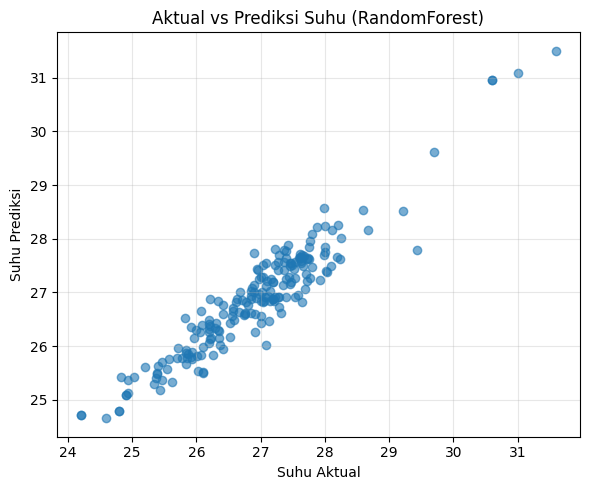


Distribusi label Awan (bucketed):


,Kategori,Jumlah
0,Hujan,751
1,Mendung,104
2,Cerah Berawan,108
3,Cerah,37



Evaluasi Klasifikasi (Awan)


,precision,recall,f1-score,support
Cerah,1.000,0.286,0.444,7.00
Cerah Berawan,0.810,0.773,0.791,22.00
Hujan,0.847,0.960,0.900,150.00
Mendung,0.429,0.143,0.214,21.00
accuracy,0.830,0.830,0.830,0.83
macro avg,0.771,0.540,0.587,200.00
weighted avg,0.804,0.830,0.800,200.00


Accuracy keseluruhan: 0.830


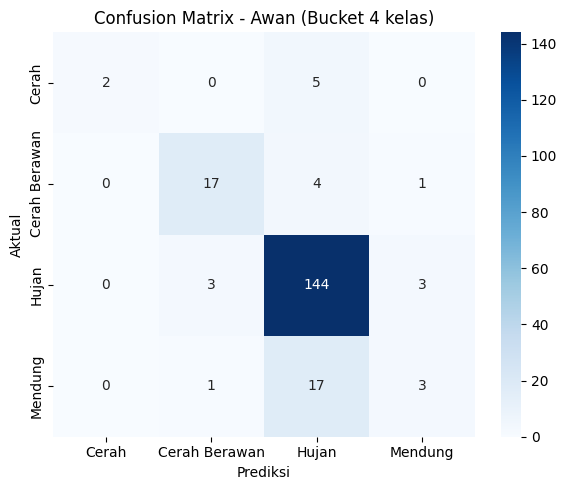


Feature Importance (Klasifikasi Awan)


,Fitur,Importance
3,Suhu,0.413542
0,Angin,0.318758
2,Kelembaban,0.267700
1,Curah_Hujan,0.000000



Insight Klasifikasi


,Insight
0,Accuracy 0.83. Model stabil dengan bucket 4 ke...
1,Fitur dominan: Suhu & Kelembaban.
2,Untuk label asli banyak kelas: pertimbangkan S...



Contoh prediksi (10 baris):


,Angin,Curah_Hujan,Kelembaban,Suhu,Awan_Actual,Awan_Predicted
746,0.68,0.0,80,26.97,Hujan,Hujan
751,2.70,0.0,83,26.99,Cerah,Hujan
284,4.48,0.0,91,25.57,Hujan,Hujan
877,1.68,0.0,87,26.49,Hujan,Hujan
851,0.90,0.0,86,25.93,Hujan,Hujan
969,2.86,0.0,86,27.47,Cerah,Cerah
787,3.54,0.0,77,27.36,Hujan,Hujan
797,4.97,0.0,80,27.23,Hujan,Hujan
926,1.15,0.0,85,26.39,Hujan,Hujan
840,2.05,0.0,90,25.53,Mendung,Hujan


In [ ]:
# ---------- Import library ----------
import warnings
warnings.filterwarnings("ignore")  # hilangkan warning yang tidak penting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    classification_report, accuracy_score, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# ---------- Konfigurasi ----------
N_ROWS = 1000                   # jumlah baris untuk testing (bisa full dataset nanti)
DATA_PATH = "../data/cuaca_clean.csv"
RANDOM_STATE = 42               # untuk reproducibility

# ---------- Load dan persiapan data ----------
df = pd.read_csv(DATA_PATH, nrows=N_ROWS)

# cek apakah kolom wajib ada
required = ['Tanggal','Suhu','Curah_Hujan','Kelembaban','Angin','Awan']
assert set(required).issubset(df.columns), "Kolom wajib tidak lengkap."

# ubah tipe data
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')
for col in ['Suhu','Kelembaban','Curah_Hujan','Angin']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# salin dataframe untuk regresi dan klasifikasi
df_reg = df.copy()
df_clf = df.copy()

# =======================
# (A) REGRESI: Prediksi SUHU
# =======================
reg_df = df_reg[['Angin','Curah_Hujan','Kelembaban','Awan','Suhu']].copy()

# encode kolom kategorikal 'Awan'
if reg_df['Awan'].dtype == 'object':
    le_reg = LabelEncoder()
    reg_df['Awan_encoded'] = le_reg.fit_transform(reg_df['Awan'].astype(str))
else:
    reg_df['Awan_encoded'] = reg_df['Awan']

# pastikan semua kolom numeric
for c in ['Angin','Curah_Hujan','Kelembaban','Awan_encoded','Suhu']:
    reg_df[c] = pd.to_numeric(reg_df[c], errors='coerce')

# buang baris yang targetnya NaN
reg_df = reg_df.dropna(subset=['Suhu'])

# imputasi nilai kosong dengan mean
reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']] = \
    reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']].fillna(reg_df.mean(numeric_only=True))

# pisah fitur dan target
X_reg = reg_df[['Angin','Curah_Hujan','Kelembaban','Awan_encoded']]
y_reg = reg_df['Suhu']

# split train-test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

# inisialisasi dan fit model RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)

# ---------- Evaluasi regresi ----------
eval_reg = pd.DataFrame({
    "Metrik": ["MSE", "R²"],
    "Nilai": [mean_squared_error(y_test_r, y_pred_r), r2_score(y_test_r, y_pred_r)]
}).round(4)
print("=== Evaluasi Regresi ===")
display(eval_reg)

# Feature importance regresi
fi_reg = pd.DataFrame({
    "Fitur": X_reg.columns,
    "Importance": regressor.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nFeature Importance (Regresi Suhu)")
display(fi_reg)

# Insight regresi
insight_reg = pd.DataFrame({
    "Insight": [
        f"R² = {r2_score(y_test_r, y_pred_r):.2f} (semakin dekat 1, semakin baik).",
        "Kelembaban dan/atau Curah_Hujan biasanya dominan memengaruhi prediksi suhu.",
        "Model cocok untuk estimasi suhu jangka pendek."
    ]
})
print("\nInsight Regresi")
display(insight_reg)

# Scatter plot prediksi vs aktual
plt.figure(figsize=(6,5))
plt.scatter(y_test_r[:200], y_pred_r[:200], alpha=0.6)
plt.xlabel("Suhu Aktual")
plt.ylabel("Suhu Prediksi")
plt.title("Aktual vs Prediksi Suhu (RandomForest)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =======================
# (B) KLASIFIKASI: Prediksi Kategori AWAN
# =======================
clf_base = df_clf[['Angin','Curah_Hujan','Kelembaban','Suhu','Awan']].copy()
clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']] = \
    clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']].apply(pd.to_numeric, errors='coerce')

# imputasi nilai kosong
clf_base['Curah_Hujan'] = clf_base['Curah_Hujan'].fillna(0)
clf_base['Angin'] = clf_base['Angin'].fillna(clf_base['Angin'].median())
clf_base['Kelembaban'] = clf_base['Kelembaban'].fillna(clf_base['Kelembaban'].median())
clf_base['Suhu'] = clf_base['Suhu'].fillna(clf_base['Suhu'].median())
clf_base = clf_base.dropna(subset=['Awan'])

# bucket label awan ke 4 kategori
def bucket_awan(val):
    if pd.api.types.is_number(val):
        v = float(val)
        if v <= 20: return "Cerah"
        elif v <= 45: return "Cerah Berawan"
        elif v <= 75: return "Mendung"
        else: return "Hujan"
    else:
        return str(val)

clf_base['Awan_bucket'] = clf_base['Awan'].apply(bucket_awan)

# tampilkan distribusi label
print("\nDistribusi label Awan (bucketed):")
display(pd.DataFrame(Counter(clf_base['Awan_bucket']).items(), columns=["Kategori", "Jumlah"]))

# pisah fitur dan target
X_clf = clf_base[['Angin','Curah_Hujan','Kelembaban','Suhu']]
y_clf_bucket = clf_base['Awan_bucket']

# split train-test (stratify supaya proporsi label sama)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf_bucket, test_size=0.2, random_state=RANDOM_STATE,
    stratify=y_clf_bucket if len(set(y_clf_bucket)) > 1 else None
)

# inisialisasi dan fit RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE,
                                    class_weight='balanced_subsample', n_jobs=-1)
classifier.fit(X_train_c, y_train_c)
y_pred_c = classifier.predict(X_test_c)

# Evaluasi klasifikasi
acc = accuracy_score(y_test_c, y_pred_c)
report = classification_report(y_test_c, y_pred_c, zero_division=0, output_dict=True)
eval_clf = pd.DataFrame(report).T.round(3)
print("\nEvaluasi Klasifikasi (Awan)")
display(eval_clf)
print(f"Accuracy keseluruhan: {acc:.3f}")

# Confusion matrix visual
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_c, y_pred_c, labels=sorted(y_train_c.unique()))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y_train_c.unique()),
            yticklabels=sorted(y_train_c.unique()))
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Awan (Bucket 4 kelas)")
plt.tight_layout()
plt.show()

# Feature importance klasifikasi
fi_clf = pd.DataFrame({
    "Fitur": X_clf.columns,
    "Importance": classifier.feature_importances_
}).sort_values("Importance", ascending=False)
print("\nFeature Importance (Klasifikasi Awan)")
display(fi_clf)

# Insight klasifikasi
insight_clf = pd.DataFrame({
    "Insight": [
        f"Accuracy {acc:.2f}. Model stabil dengan bucket 4 kelas.",
        "Fitur dominan: Suhu & Kelembaban.",
        "Untuk label asli banyak kelas: pertimbangkan SMOTE atau penggabungan kelas jarang."
    ]
})
print("\nInsight Klasifikasi")
display(insight_clf)

# Contoh prediksi
out = X_test_c.copy()
out['Awan_Actual'] = y_test_c
out['Awan_Predicted'] = y_pred_c
print("\nContoh prediksi (10 baris):")
display(out.head(10))
